# Overview
- nb017の改良
- feature importanceを出力する仕様にする
- 特徴量ロード駆動にする

# Const

In [1]:
NB = '020'
ADD_FEATS = ['feature_basic01', 'feature_name_has']

PATH_TRAIN = './../data/official/train.csv'
PATH_TEST = './../data/official/test.csv'
PATH_SAMPLE_SUBMITTION = './../data/official/atmaCup8_sample-submission.csv'
SAVE_DIR = f'../data/output_nb/nb{NB}/'

feat_train_only = ['JP_Sales', 'Global_Sales', 'NA_Sales', 'Other_Sales', 'EU_Sales']
feat_common = ['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher',
           'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer',
           'Rating']
feat_string = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
feat_cat = ['Platform', 'Genre', 'Rating']
feat_num = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
use_col = [
    'Platform',
    'Year_of_Release',
    'Genre',
    'Critic_Score',
    'Critic_Count',
    'User_Score',
    'User_Count',
    'Rating'
    ]

In [27]:
config_str = """
globals:
  seed: 2020
  show_log: True

feature:
    use_col: [
        'Platform',
        'Year_of_Release',
        'Genre',
        'Critic_Score',
        'Critic_Count',
        'User_Score',
        'User_Count',
        'Rating'
        ]

split:
  name: KFold
  params:
    n_splits: 5
    random_state: 2020
    shuffle: True

model:
    model_params:
        objective: 'regression'
        metric: 'rmse'
        importance_type: 'gain'
        n_estimators: 800
        max_depth: 131
        subsample: 0.6
        colsample_bytree: 0.9
        learning_rate: 0.022862256818781214
        reg_alpha: 1.0
        reg_lambda: 6.0
        min_child_samples: 10
    
    train_params:
        categorical_feature: ['Platform', 'Genre', 'Rating']
        verbose: 30
        early_stopping_rounds: 100
"""



# Import everything I need :)

In [28]:
import os
import time
import yaml
import types
import builtins
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor 

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.filterwarnings('ignore')

# My function

In [29]:
# noglobal

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [30]:
@noglobal
def metric(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred) ** .5

@noglobal
def preprocess_User_Score(df):
    '''
    - tbdをnanにする
    - stringをfloatにする
    '''
    mask = df.User_Score.values == 'tbd'
    df.User_Score[mask] = np.nan
    df.User_Score = df.User_Score.values.astype(float)
    return df

@noglobal
def string_encode(df_trn, df_te, cols):
    '''
    - np.nanがあれば、'nan'に置き換える
    - label encodingする
    '''
    df = pd.concat([df_trn, df_te], axis=0).copy()
    df[cols] = df[cols].replace(np.nan, 'nan')
    df_trn[cols] = df_trn[cols].replace(np.nan, 'nan')
    df_te[cols] = df_te[cols].replace(np.nan, 'nan')
    for col in cols:
        le = LabelEncoder()
        le.fit(df[col])
        df_trn[col] = le.transform(df_trn[col])
        df_te[col] = le.transform(df_te[col])
    return df_trn, df_te

@noglobal
def df_preprocessing(df_trn, df_te, string_cols):
    df_trn = preprocess_User_Score(df_trn)
    df_te = preprocess_User_Score(df_te)
    df_trn, df_te = string_encode(df_trn, df_te, string_cols)
    return df_trn, df_te

@noglobal
def visualize_importance(models, feat_train_df):
    """
    lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    ref: https://www.guruguru.science/competitions/13/discussions/d8f2d66a-aeee-4789-8b3d-d5935c26b1b7/

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

In [31]:
@noglobal
def run_fold_lgbm(_X_trn, _y_trn, _X_val, _y_val, _X_te, model_config, show_log=True):
    model_params = model_config['model_params']
    train_params = model_config['train_params']
    
    # train
    model = LGBMRegressor(**model_params)
    model.fit(_X_trn, _y_trn.values[:, 0],
              eval_set=[(_X_trn, _y_trn), (_X_val, _y_val)],
              **train_params
             )
    
    # predict
    y_trn_pred = model.predict(_X_trn)
    y_val_pred = model.predict(_X_val)
    _y_test_pred = model.predict(_X_te)
    
    # postprocessiing
    y_trn_pred[y_trn_pred <= 1] = 1
    y_val_pred[y_val_pred <= 1] = 1
    y_trn_pred = np.expm1(y_trn_pred)  # exp を適用して 1 を引く
    y_val_pred = np.expm1(y_val_pred)  # exp を適用して 1 を引く
    _y_test_pred = np.expm1(_y_test_pred)  # exp を適用して 1 を引く
    
    if show_log:
        print(show_log)
        print(f'score train: {metric(np.expm1(_y_trn), y_trn_pred):.5f}')
        print(f'score valid: {metric(np.expm1(_y_val), y_val_pred):.5f}')
        print('')
    
    return y_trn_pred, y_val_pred, _y_test_pred, model

@noglobal
def run_lgbm(X, y, X_te, splitter, config):
    show_log = config['globals']['show_log']
    model_config = config['model']

    models = []
    oof = np.zeros(len(X))
    y_test_pred = np.zeros(len(X_te))
    for fold_i, (idx_trn, idx_val) in enumerate(splitter.split(X)):
        if show_log:
            print(f'::Fold {fold_i+1}/{splitter.n_splits} start at {time.ctime()}::')
        X_trn, X_val = X.iloc[idx_trn, :], X.iloc[idx_val, :]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        X_trn = pd.DataFrame(X_trn, columns=X.columns)
        X_val = pd.DataFrame(X_val, columns=X.columns)

        # train
        y_trn_pred, y_val_pred, _y_test_pred, model = run_fold_lgbm(X_trn, y_trn, X_val, y_val, 
                                                                 X_te, model_config, 
                                                                 show_log=show_log)

        # result
        oof[idx_val] = y_val_pred
        y_test_pred += _y_test_pred / splitter.n_splits
        models.append(model)


    y_test_pred[y_test_pred <= 1] = 1
    return oof, y_test_pred, models

# Preparation

set

In [32]:
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

config = yaml.safe_load(config_str)

<br>

load dataset

In [33]:
train = pd.read_csv(PATH_TRAIN)
test = pd.read_csv(PATH_TEST)
ss = pd.read_csv(PATH_SAMPLE_SUBMITTION)

In [34]:
path_list = sorted(glob(f'../data/output_nb/*/*'))

<br>

preprocess

In [35]:
# train, test = df_preprocessing(train, test, feat_string)

In [36]:
# X = train[use_col].copy()
y = train[['Global_Sales']].copy()
# X_te = test[use_col].copy()

In [37]:
X = pd.DataFrame()
X_te = pd.DataFrame()
for feat_name in ADD_FEATS:
    for path in path_list:
        if f'train_{feat_name}.csv' in path:
            feat = pd.read_csv(path)
            X = pd.concat([X, feat], axis=1)
        if f'test_{feat_name}.csv' in path:
            feat = pd.read_csv(path)
            X_te = pd.concat([X_te, feat], axis=1)

In [38]:
X.head()

,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Name_has_super,Name_has_world,...,Name_has_collection,Name_has_man,Name_has_sonic,Name_has_battle,Name_has_quest,Name_has_portable,Name_has_shin,Name_has_disney,Name_has_baseball,Name_has_soccer
0,26,NaN,0,74.0,17.0,7.9,22.0,2,False,False,...,False,False,False,False,False,False,False,False,False,False
1,26,NaN,0,78.0,22.0,6.6,28.0,2,False,False,...,False,False,False,False,False,False,False,False,False,False
2,19,NaN,0,73.0,5.0,7.4,10.0,2,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,NaN,0,NaN,NaN,NaN,NaN,8,False,False,...,False,False,False,False,False,False,False,False,False,False
4,26,NaN,0,76.0,8.0,7.8,13.0,2,False,False,...,False,False,False,False,False,False,False,False,False,False


In [39]:
# RMSLE を RMSEとしいて解く
y = np.log1p(y)  # 1 を足してlog を適用

# Create Model

In [40]:
splitter = KFold(**config['split']['params'])

In [41]:
%%time
print(f"use_col: {X.columns}")
oof, y_test_pred, models = run_lgbm(X, y, X_te, splitter, config)
print(f'oof score: {metric(np.expm1(y), oof):.5f}')

use_col: Index(['Platform', 'Year_of_Release', 'Genre', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Rating', 'Name_has_super',
       'Name_has_world', 'Name_has_star', 'Name_has_lego', 'Name_has_game',
       'Name_has_dragon', 'Name_has_ds', 'Name_has_mario', 'Name_has_final',
       'Name_has_fantasy', 'Name_has_vs.', 'Name_has_collection',
       'Name_has_man', 'Name_has_sonic', 'Name_has_battle', 'Name_has_quest',
       'Name_has_portable', 'Name_has_shin', 'Name_has_disney',
       'Name_has_baseball', 'Name_has_soccer'],
      dtype='object')
::Fold 1/5 start at Wed Dec  9 23:06:41 2020::
Training until validation scores don't improve for 100 rounds
[30]	valid_0's rmse: 1.14791	valid_1's rmse: 1.14934
[60]	valid_0's rmse: 1.0433	valid_1's rmse: 1.06193
[90]	valid_0's rmse: 0.992311	valid_1's rmse: 1.02426
[120]	valid_0's rmse: 0.961836	valid_1's rmse: 1.00423
[150]	valid_0's rmse: 0.940321	valid_1's rmse: 0.991064
[180]	valid_0's rmse: 0.924477	valid_1'

# create sub

In [42]:
ss['Global_Sales'] = y_test_pred
save_path = f'{SAVE_DIR}submission.csv'
ss.to_csv(save_path, index=False)

print(f'save: {save_path}')

save: ../data/output_nb/nb020/submission.csv


# Analysis

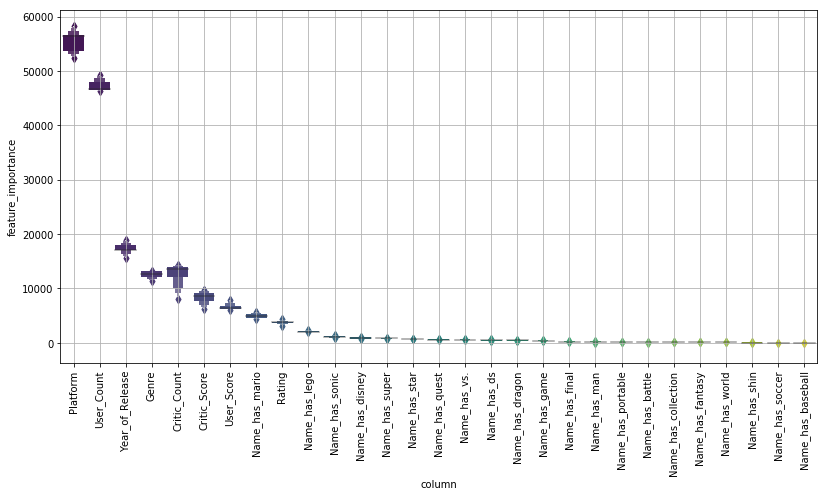

In [43]:
fig, ax = visualize_importance(models, X)

Text(0, 0.5, 'Pred')

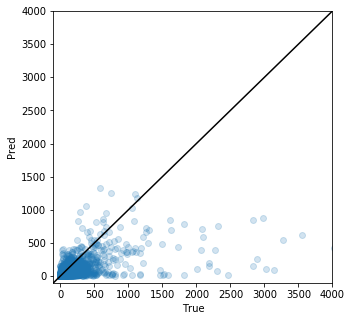

In [19]:
plt.figure(figsize=(5, 5))
plt.plot([-200, 8000], [-200, 8000], color='black')
plt.scatter(np.expm1(y), oof, alpha=0.2)
plt.xlim(-100, 4000)
plt.ylim(-100, 4000)
plt.xlabel('True')
plt.ylabel('Pred')

(-100, 1000)

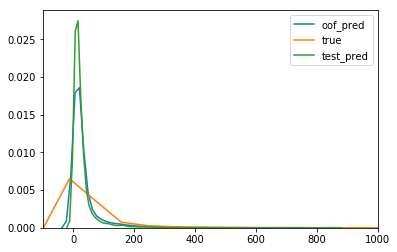

In [26]:
sns.kdeplot(oof, label='oof_pred')
sns.kdeplot(np.expm1(y.Global_Sales.values), label='true')
sns.kdeplot(y_test_pred, label='test_pred')
plt.xlim(-100, 1000)